# TSTpatching Notebook

 ### 1. Overview & Purpose
 
This notebook demonstrates a systematic approach to understanding and intervening in a Transformer-based time series classifier.
1. **Capture internal activations**.  Cache convolutional embeddings, self-attention outputs, and MLP activations for clean inputs.
2. **Perform targeted patches**. Replace activations from corrupted inputs with those from clean inputs at various granularities (entire heads, individual positions, or MLP layers).
3. **Quantify influence**. Measure how each patch affects the model’s class probabilities to locate the most critical components for correct predictions.
4. **Identify causal circuits**. Aggregate significant patches into a graph of input timesteps → attention heads to reveal pathways driving the model’s decisions.
5. **Visualize results**. Use heatmaps, saliency overlays, and network graphs to interpret and communicate findings.
 

### 2. Imports and Dependencies
- Common Python packages
- Utility / Helper functions for plotting and backend processing from utils.py file
- Aeon for TSC dataset loading
- TST architecture from TSTtrainer.py
- Widgets for interactive notebook

In [28]:
# autoreload for utils.py edits
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

# helper library
from utils import (
    sweep_heads,
    sweep_layerwise_patch,
    sweep_mlp_layers,
    sweep_attention_head_positions,
    sweep_mlp_positions,
    plot_influence,
    plot_layerwise_influence,
    plot_mlp_influence,
    plot_head_position_patch_heatmap,
    plot_mlp_position_patch_heatmap,
    get_attention_saliency,
    plot_timeseries_with_attention_overlay,
    get_probs,
    find_critical_patches,
    build_causal_graph,
    plot_causal_graph,
    plot_structured_graph_with_heads,
    patch_multiple_attention_heads_positions,
    patch_attention_head_at_position,
    sweep_head_to_head_influence,
    sweep_head_to_output_deltas

)

from aeon.datasets import load_classification
from TSTtrainer import TimeSeriesTransformer

import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact, IntSlider, FloatSlider, fixed

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 3. Dataset Preparation
Define the dataset we want to work on here, the preprocess it for model input.

Currently there are three options:
- JapaneseVowels (12 dimension, 9 classes)
- FaceDetection (144 dimensions, 2 classes) NOTE: *model has ~50% accuracy*
- Yoga (1 dimension, 2 classes)

In [29]:
DATASET_NAME = "JapaneseVowels"

In [30]:
X_train, y_train = load_classification(DATASET_NAME, split="train")
X_test, y_test = load_classification(DATASET_NAME, split="test")

# swap axes to (N, seq_len, 1) and convert to float32
def prep(X):
    X_np = X.astype(np.float32)
    return np.swapaxes(X_np, 1, 2)

X_test = torch.tensor(prep(X_test))
y_test = torch.tensor(y_test.astype(np.int64))

# print(f"X_test = {X_test.shape}, Y_test = {y_test.shape}")
print(f"Test set has {X_test.shape[0]} instances, each instance has {X_test.shape[1]} timesteps across {X_test.shape[2]} dimensions.")
print(f"For each instance in the test set there is a true label.")

Test set has 370 instances, each instance has 25 timesteps across 12 dimensions.
For each instance in the test set there is a true label.


### 4. Model Initialization
Set up the TST model and load the pretrained checkpoint.
- Use GPU if available, however evaluation completely feasible on a laptop.
- Model must be instantiated exactly as the pretrained one.

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# extract data dimensions
seq_len = X_test.shape[1]
input_dim = X_test.shape[2]
num_classes = y_test.max() + 1

# model parameters, do not change
model = TimeSeriesTransformer(
    input_dim=input_dim,
    num_classes=num_classes,
    seq_len=seq_len,
    d_model=128,
    n_head=8,
    num_encoder_layers=3,
    dim_feedforward=256,
    dropout=0.1
).to(device)

num_layers = len(model.transformer_encoder.layers)

# load pretrained model
MODEL_NAME = f"TST_{DATASET_NAME.lower()}.pth"
model.load_state_dict(torch.load(MODEL_NAME, map_location=device, weights_only=True))

<All keys matched successfully>

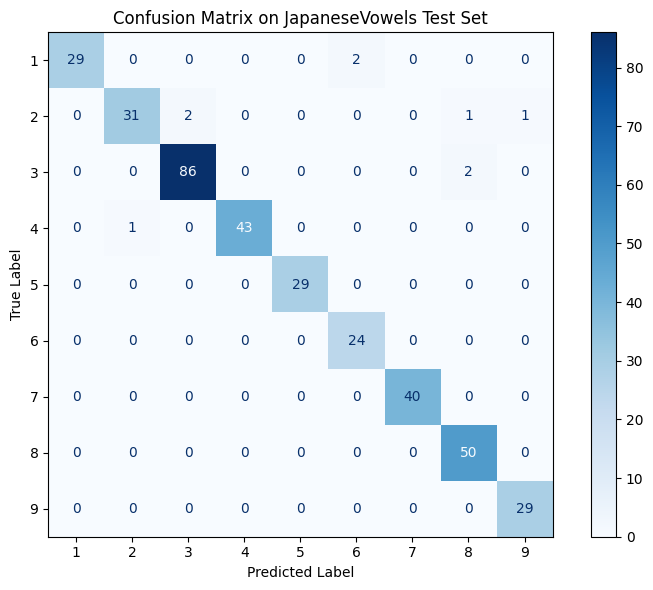

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Put model in evaluation mode
model.eval()

# Move test data to the correct device
X_test_device = X_test.to(device)

# Step 1: Get predictions
with torch.no_grad():
    logits = model(X_test_device)
    predictions = torch.argmax(logits, dim=1).cpu().numpy()
    labels = y_test.cpu().numpy()

# Step 2: Compute confusion matrix
cm = confusion_matrix(labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(1, 10))

# Step 3: Plot
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap="Blues", ax=ax, values_format="d")
plt.title(f"Confusion Matrix on {DATASET_NAME} Test Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


### 5. Identify Misclassified Examples
Scan trough the test set to find instances where the model predicts the wrong label.
- Sorted by confindence
- Reveal possible targets for patching

In [33]:
model.eval()
misclassified = []
with torch.no_grad():
    for idx in range(len(X_test)):
        x = X_test[idx:idx+1].to(device)
        logits = model(x)
        probs  = torch.softmax(logits, dim=1)
        pred   = probs.argmax(dim=1).item()
        true   = y_test[idx].item()
        if pred != true:
            misclassified.append({
                "idx": idx,
                "true_label": true,
                "pred_label": pred,
                "P_true": probs[0, true].item(),
                "P_pred": probs[0, pred].item()
            })

df_mis = pd.DataFrame(misclassified).sort_values(by="P_true", ascending=True)
df_mis.reset_index(drop=True, inplace=True)
df_mis

,idx,true_label,pred_label,P_true,P_pred
0,36,2,8,0.006204,0.993416
1,170,4,2,0.034819,0.964566
2,46,2,3,0.087674,0.911487
3,44,2,3,0.107246,0.892122
4,31,2,9,0.113604,0.640457
5,114,3,8,0.184978,0.812860
6,20,1,6,0.365815,0.632164
7,127,3,8,0.375168,0.607927
8,1,1,6,0.408085,0.546106


### 6. Selection of instances
1. Denoising: 
    - 1st: *Clean* instance (correct classification)
    - 2nd: *Corrupted* instance (misclassified)
2. Noising:
    - Vice-versa

In [34]:
# CHOOSE 2 INSTANCES
idx_1 = 33
idx_2 = 44

# move both instances to device and store ground truth
x1 = X_test[[idx_1]].to(device)
y1 = y_test[[idx_1]].item()

x2 = X_test[[idx_2]].to(device)
y2 = y_test[[idx_2]].item()

# verify model predictions
probs_x1 = torch.softmax(model(x1), dim=1)[0][y1].detach().cpu().numpy()
probs_x2 = torch.softmax(model(x2), dim=1)[0][y2].detach().cpu().numpy()
probs_x1_pct = probs_x1 * 100
probs_x2_pct = probs_x2 * 100

print(f"Instance {idx_1} ground truth label is {y1}, Instance {idx_2} ground truth label is {y2}.")
print(f"The model predicted {y1} for instance {idx_1} with {probs_x1_pct:.2f}% confidence. "
      f"For instance {idx_2} the confidence for label {y2} is {probs_x2_pct:.2f}%.")

Instance 33 ground truth label is 2, Instance 44 ground truth label is 2.
The model predicted 2 for instance 33 with 100.00% confidence. For instance 44 the confidence for label 2 is 10.72%.


### 7. Visualizing raw Time Series for the selected instances
First look at the structure of the sequences we are investigating

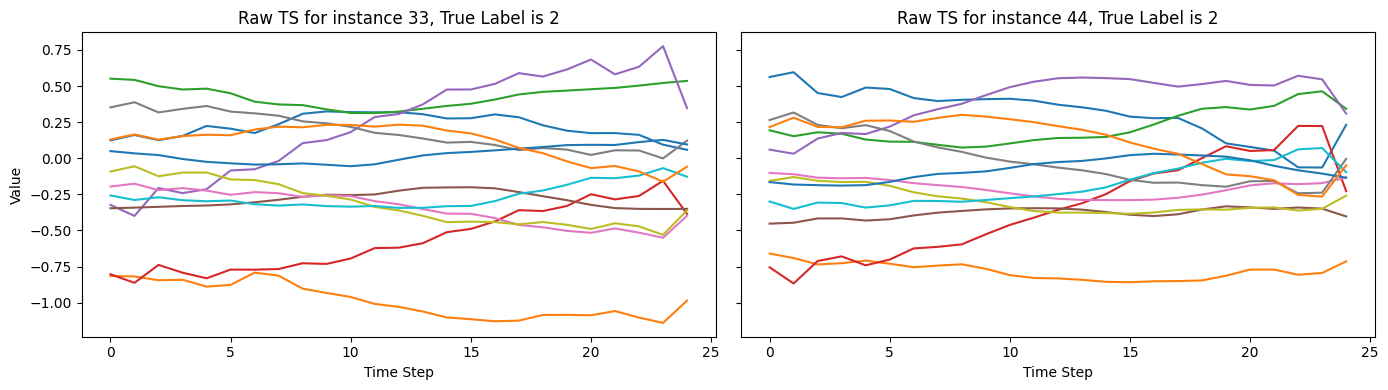

In [35]:
series_idx_1 = x1.cpu().numpy().squeeze()
series_idx_2 = x2.cpu().numpy().squeeze()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 4), sharey=True)

axes[0].plot(x1.squeeze().cpu().numpy())
axes[0].set_title(f"Raw TS for instance {idx_1}, True Label is {y1}")
axes[0].set_xlabel("Time Step")
axes[0].set_ylabel("Value")

axes[1].plot(x2.squeeze().cpu().numpy())
axes[1].set_title(f"Raw TS for instance {idx_2}, True Label is {y2}")
axes[1].set_xlabel("Time Step")

plt.tight_layout()
plt.show()

## Patching Experiment: PATCHING EACH ATTENTION HEAD
- **get_probs** records the model's baseline prediction probabilities on the 2nd instance to provide a reference point.
- **sweep_heads** systematically patches each attention head (one at a time) from the first instance into the other while recording the resulting class probabilities.


In [36]:
baseline = get_probs(model, x2)
x1 = x1.squeeze(0)
x2 = x2.squeeze(0)


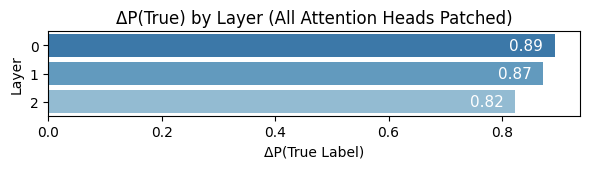

In [37]:
# Run patch sweep across layers (patch all heads at once per layer)
patched_probs_per_layer = sweep_layerwise_patch(model, x1, x2, num_classes)


# DETERMINE BASELINE


# Plot ΔP per layer for the true label
plot_layerwise_influence(patched_probs_per_layer, baseline, y2)


In [38]:

# PATCH EACH HEAD
patch_probs = sweep_heads(model, x1, x2, num_classes)

### Visualzing Influnece via Heatmap
**plot_influence** computes tbe change in proability  for true label and (ΔP) when each head is patched

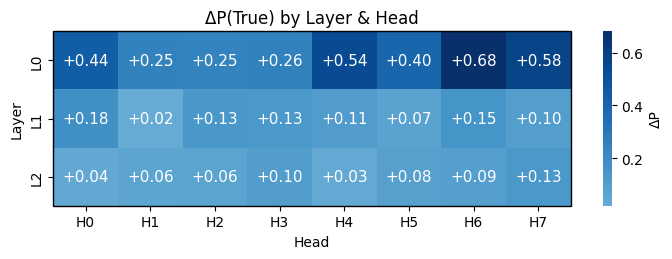

In [39]:
plot_influence(patch_probs, baseline, y2)

X-axis: Attention heads.

Y-axis: Transformer layers.

Cell values: ΔP(true label).

**Interpretation**: Brighter colors indicate heads that, when patched, most improve the model's confidence in the true label

### Attention Overlay
Overlay the attention saliency scores onto the raw time series plots
- Choose a specific (*layer, head*) combination to inspect.

**get_attention_saliency** extracts per-timestep attention weights for each instance

**plot_timeseries_with_attention_overlay** displays the original time series with attention scores visualized as highlighted regions

In [40]:
@interact(
    layer_idx=IntSlider(min=0, max=num_layers-1, step=1, value=0),
    head_idx=IntSlider(min=0, max=7, step=1, value=0)
)
def plot_attention_overlay(layer_idx, head_idx):
    instances = [x1, x2]
    saliencies = [get_attention_saliency(model, inst, layer_idx, head_idx) for inst in instances]
    labels = ["x1", "x2"]

    plot_timeseries_with_attention_overlay(
        instances=[inst.squeeze(0) for inst in instances],
        saliencies=saliencies,
        labels=labels,
        title=f"Layer {layer_idx} Head {head_idx} Attention Overlay"
    )


interactive(children=(IntSlider(value=0, description='layer_idx', max=2), IntSlider(value=0, description='head…

The colored bands behind the time series indicate how much attention this head pays to each timestep.

Brighter mean higher attention.

Darker bands mean lower attention.

### Patching a specific head at each timestep

**sweep_attention_head_positions** patches the output of each individual head at every position (time step). It then records how patching at each position affects the model’s confidence in the true label.

**plot_head_position_patch_heatmap** shows how important each timestep is for the selected head

In [41]:
patch_probs_heads = sweep_attention_head_positions(model, x1, x2, num_layers, 8, seq_len, num_classes)

@interact(
    layer_idx=IntSlider(min=0, max=num_layers-1, step=1, value=0),
    head_idx=IntSlider(min=0, max=7, step=1, value=0)
)
def plot_patch_effect_heatmap(layer_idx, head_idx):
    plot_head_position_patch_heatmap(
        patch_probs=patch_probs_heads,
        baseline_probs=baseline,
        true_label=y2,
        layer_idx=layer_idx,
        head_idx=head_idx,
        title=f"Head {head_idx} in Layer {layer_idx} - Patch Effect across Time Steps"
    )

interactive(children=(IntSlider(value=0, description='layer_idx', max=2), IntSlider(value=0, description='head…

X-axis: Time steps (positions).

Y-axis: Specific (layer, head) combination.

Colors: Change in model probability for the true label.

## Patching Experiment: PATCHING MLP LAYERS

**sweep_mlp_layers** patches the MLP output (after the second linear layer) of each transformer encoder layer individually

**plot_mlp_influence** visualizes the ΔP(true label) from patching each MLP layer

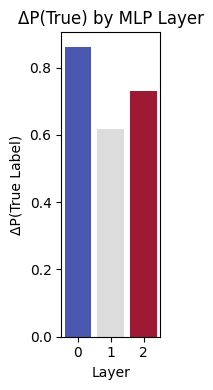

In [42]:
patch_probs_mlp = sweep_mlp_layers(model, x1, x2, num_classes=num_classes)
plot_mlp_influence(patch_probs_mlp, baseline, true_label=y2)

X-axis: Transformer layers.

Y-axis: Change in model confidence for the true label.

**Interpretation**: Higher positive bars indicate layers whose MLP activations help recover the correct classification more.


### Patching MLP layer at a specific position
**sweep_mlp_positions** patches the MLP activation at each time step. Measure how patching each position’s MLP output affects the true label probability.

**plot_mlp_position_patch_heatmap** shows a heatmap of influence over layers and positions.

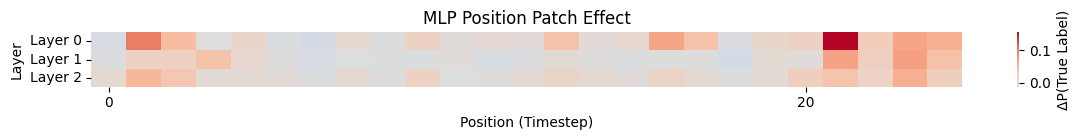

In [43]:
patch_probs_mlp_pos = sweep_mlp_positions(model, x1, x2, num_layers, seq_len, num_classes)
plot_mlp_position_patch_heatmap(
    patch_probs_mlp_pos, 
    baseline, 
    true_label=y2,
    title="MLP Position Patch Effect"
)

X-axis: Time steps (positions).

Y-axis: Transformer layers.

Colors: Change in model probability for the true label.

## BUILDING CAUSAL GRAPHS

### Identify most critical inteventions and build a graph
- Select (layer, head, position) triples where patching yields a positive ΔP (above threshold).
- Create a directed graph where input timesteps point to important heads.
- Visualize the causal graph with nodes and weighted edges.

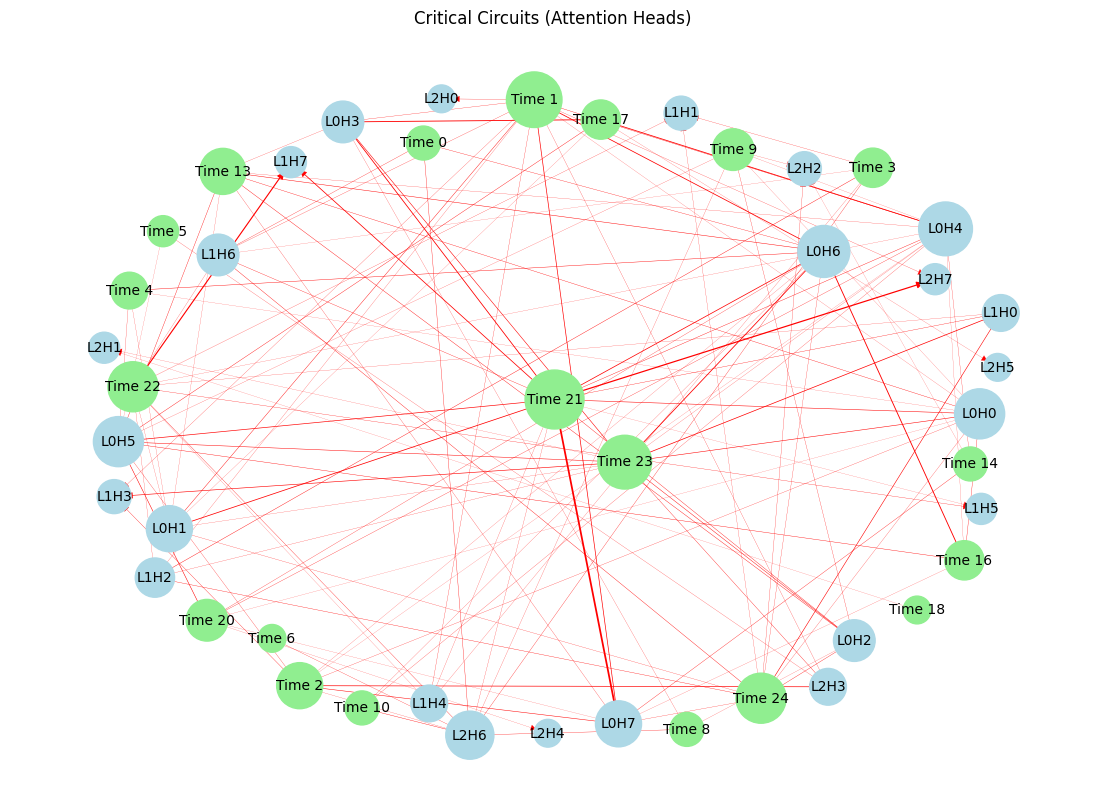

In [44]:
# define threshold
threshold = 0.01 # % of how much the probability must change

critical_patches = find_critical_patches(
    patch_probs_heads, 
    baseline,
    true_label=y2,
    threshold=threshold
)

G = build_causal_graph(critical_patches)
plot_causal_graph(G, title="Critical Circuits (Attention Heads)")

**Input nodes**: Specific timesteps (e.g., "Time 12").

**Head nodes**: Attention heads (e.g., "L0H5").

Larger nodes imply more edges are connected to it.

Brighter edges imply magnitude of ΔP is larger after patching.

### Node Degrees and Edge Weights
**Node degrees**: How many edges connect to each node (importance as a hub).

**Edge weights**: How much each causal connection improves model performance.

Nodes and edges are ranked by influence

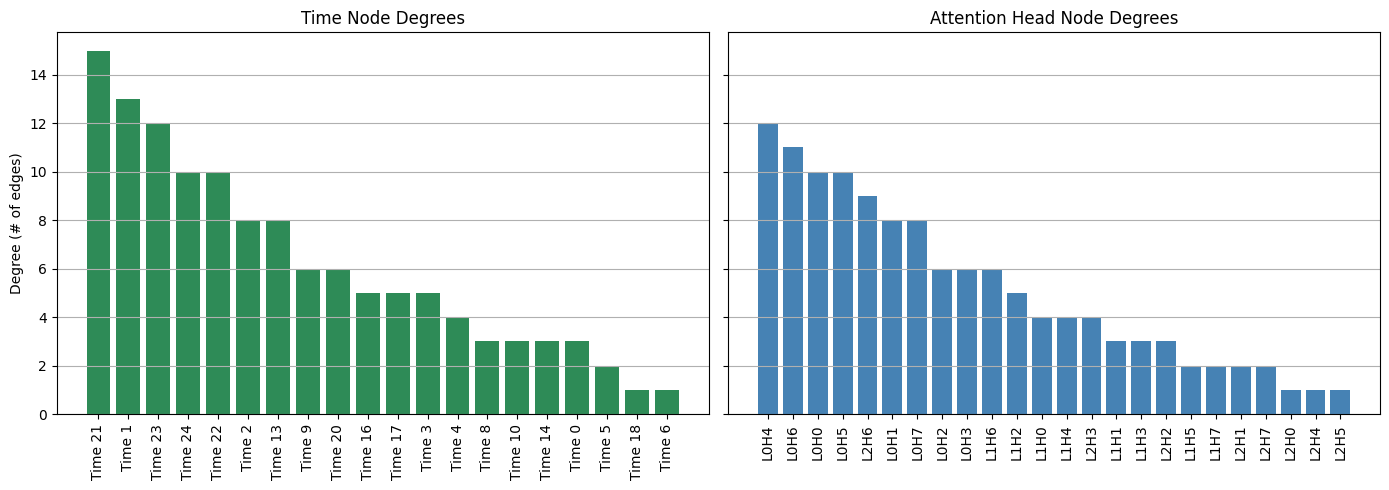

In [45]:
degrees = dict(G.degree())
sorted_degrees = sorted(degrees.items(), key=lambda x: x[1], reverse=True)
names = [x[0] for x in sorted_degrees]
values = [x[1] for x in sorted_degrees]

edges = list(G.edges(data=True))
sorted_edges = sorted(edges, key=lambda x: x[2]['weight'], reverse=True)
sources = [f"{u}->{v}" for u,v,d in sorted_edges]
weights = [d['weight'] for u,v,d in sorted_edges]

time_names = []
head_names = []
time_values = []
head_values = []

for name, val in zip(names, values):
    if name.startswith("Time"):
        time_names.append(name)
        time_values.append(val)
    elif name.startswith("L") and "H" in name:
        head_names.append(name)
        head_values.append(val)

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)


axes[0].bar(time_names, time_values, color="seagreen")
axes[0].set_title("Time Node Degrees")
axes[0].set_ylabel("Degree (# of edges)")
axes[0].tick_params(axis='x', rotation=90)
axes[0].grid(axis='y')

axes[1].bar(head_names, head_values, color="steelblue")
axes[1].set_title("Attention Head Node Degrees")
axes[1].tick_params(axis='x', rotation=90)
axes[1].grid(axis='y')

plt.tight_layout()
plt.show()

## Interactive Experiment
Combining multiple critical patches affects model predictions.

1. Selects the top-k most influential edges.

2. Apply the clean activations to these multiple heads.

3. Report the change in confidence for the true label.

In [46]:
@interact(top_k=widgets.IntSlider(min=1, max=10, step=1, value=5))
def multi_patch_with_slider(top_k):
    critical_edges = sorted_edges[:top_k]
    logits_patched_multi = patch_multiple_attention_heads_positions(model, x1, x2, critical_edges)

    probs_multi = torch.softmax(logits_patched_multi, dim=1)[0].detach().cpu().numpy()
    delta_p_true_multi = probs_multi[y2] - baseline[y2]

    print(f"Top-k = {top_k}")
    print(f"ΔP(true) after multi-patching: {delta_p_true_multi:.4f}")
    print(f"Final P(true) after multi-patching: {probs_multi[y2]:.4f}")

interactive(children=(IntSlider(value=5, description='top_k', max=10, min=1), Output()), _dom_classes=('widget…

In [47]:
influence_matrix = sweep_head_to_head_influence(model, x1, x2)
delta_p_matrix = sweep_head_to_output_deltas(model, x1, x2, y2, num_classes)

In [48]:

def build_and_plot_graph(time_thresh=0.01, head_thresh=0.15, class_thresh=0.01):
    G = nx.DiGraph()
    
    # Time → Head
    for pos in range(patch_probs_heads.shape[2]):
        G.add_node(f"Time {pos}")
    for l in range(patch_probs_heads.shape[0]):
        for h in range(patch_probs_heads.shape[1]):
            G.add_node(f"L{l}H{h}")
            for pos in range(patch_probs_heads.shape[2]):
                delta = patch_probs_heads[l, h, pos, y2] - baseline[y2]
                if abs(delta) > time_thresh:
                    G.add_edge(f"Time {pos}", f"L{l}H{h}", weight=delta)

    # Head → Head
    for l1 in range(influence_matrix.shape[0]):
        for h1 in range(influence_matrix.shape[1]):
            for l2 in range(influence_matrix.shape[2]):
                for h2 in range(influence_matrix.shape[3]):
                    score = influence_matrix[l1, h1, l2, h2]
                    if abs(score) > head_thresh and (l1 != l2):
                        G.add_edge(f"L{l1}H{h1}", f"L{l2}H{h2}", weight=score)

    # Head → Class
    for c in range(num_classes):
        G.add_node(f"Class {c}")
    for l in range(delta_p_matrix.shape[0]):
        for h in range(delta_p_matrix.shape[1]):
            delta = delta_p_matrix[l, h]
            if abs(delta) > class_thresh:
                G.add_edge(f"L{l}H{h}", f"Class {y2}", weight=delta)

    plot_structured_graph_with_heads(G)


In [49]:
interact(
    build_and_plot_graph,
    time_thresh=FloatSlider(value=0.01, min=0.0, max=0.5, step=0.005, description='Time→Head ΔP'),
    head_thresh=FloatSlider(value=0.15, min=0.0, max=0.5, step=0.01, description='Head→Head MSE'),
    class_thresh=FloatSlider(value=0.01, min=0.0, max=0.8, step=0.005, description='Head→Class ΔP')
)


interactive(children=(FloatSlider(value=0.01, description='Time→Head ΔP', max=0.5, step=0.005), FloatSlider(va…

<function __main__.build_and_plot_graph(time_thresh=0.01, head_thresh=0.15, class_thresh=0.01)>

In [50]:
def build_and_plot_topk(
    top_k:int,
    time_thresh:float = 0.0,
    head_thresh:float = 0.0,
    class_thresh:float = 0.0
):
    # first select the top_k critical_patches by |delta|
    top_raw = sorted(critical_patches, key=lambda x: abs(x[3]), reverse=True)[:top_k]

    # build the graph with *all* nodes but no edges yet
    G = nx.DiGraph()
    # add all Time nodes
    for pos in range(patch_probs_heads.shape[2]):
        G.add_node(f"Time {pos}")
    # add all Head nodes
    for l in range(patch_probs_heads.shape[0]):
        for h in range(patch_probs_heads.shape[1]):
            G.add_node(f"L{l}H{h}")
    # add all Class nodes
    for c in range(num_classes):
        G.add_node(f"Class {c}")

    # now add only those top_k edges Time→Head
    head_to_sum = {}
    head_set = set()
    for l, h, pos, delta in top_raw:
        if abs(delta) < time_thresh:
            continue
        src = f"Time {pos}"
        dst = f"L{l}H{h}"
        G.add_edge(src, dst, weight=delta)
        head_set.add((l,h))
        head_to_sum.setdefault((l,h), 0.0)
        head_to_sum[(l,h)] += delta

    # you can filter by head_thresh here
    for l1 in range(influence_matrix.shape[0]):
        for h1 in range(influence_matrix.shape[1]):
            for l2 in range(influence_matrix.shape[2]):
                for h2 in range(influence_matrix.shape[3]):
                    if (l1,h1) not in head_set: 
                        continue
                    score = influence_matrix[l1, h1, l2, h2]
                    if abs(score) < head_thresh or l1==l2: 
                        continue
                    G.add_edge(f"L{l1}H{h1}", f"L{l2}H{h2}", weight=score)

    for (l,h), tot_delta in head_to_sum.items():
        if abs(tot_delta) < class_thresh:
            continue
        G.add_edge(f"L{l}H{h}", f"Class {y2}", weight=tot_delta)
        
    plot_structured_graph_with_heads(G,
        title=f"Top {top_k} critical patches" )
    
# wire it up:
interact(
    build_and_plot_topk,
    top_k = IntSlider(min=1, max=len(critical_patches), step=1, value=5, description="Top-K"),
    time_thresh=FloatSlider(value=0.01, min=0.0, max=0.1, step=0.005, description='Time→Head ΔP'),
    head_thresh=FloatSlider(value=0.15, min=0.0, max=0.5, step=0.01, description='Head→Head MSE'),
    class_thresh=FloatSlider(value=0.01, min=0.0, max=0.5, step=0.005, description='Head→Class ΔP')
)


interactive(children=(IntSlider(value=5, description='Top-K', max=123, min=1), FloatSlider(value=0.01, descrip…

<function __main__.build_and_plot_topk(top_k: int, time_thresh: float = 0.0, head_thresh: float = 0.0, class_thresh: float = 0.0)>